# SHAP Analysis: Model Explainability

**Goal:** Use SHAP (SHapley Additive exPlanations) to understand how the Random Forest model makes predictions.

**Model Being Analyzed:**
- **Random Forest Classifier** (best performing model from 03_Modeling.ipynb)
- **Test F1-Score:** 0.8601
- **Test AUC-ROC:** 0.9277
- **Features:** 24 (all available at prediction time - no data leakage)

**Benefits of SHAP:**
- Global feature importance (which features drive predictions)
- Local explanations for individual predictions
- Model-agnostic (works with any model)
- Quantifies contribution of each feature to each prediction

**What we'll create:**
1. Summary plot (beeswarm visualization of feature impact)
2. Feature importance bar chart
3. Individual prediction explanations for sample customers
4. Dependence plots (how each feature affects predictions)
5. Data-driven insights and actionable recommendations

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42

print("Environment ready! ✓")

Environment ready! ✓


## Load Model & Data

**Important Note on Data Leakage:**
- The modeling notebook ([03_Modeling.ipynb](03_Modeling.ipynb)) removed data leakage features
- **Removed features:** `offer_completed` (perfect leak), `offer_viewed` (temporal leak)
- **Clean dataset:** 24 features available at prediction time (offer delivery)
- This ensures the model can be deployed for real-time predictions

In [14]:
# Load processed data
processed_dir = '../Cafe_Rewards_Offers/processed'

# Load the best model (Random Forest)
model_dir = '../Cafe_Rewards_Offers/models'
rf_model = joblib.load(f'{model_dir}/random_forest.pkl')
print("✓ Loaded Random Forest model")
print(f"   Model expects {rf_model.n_features_in_} features")

# Load data
X_train = joblib.load(f'{processed_dir}/X_train_scaled.pkl')
y_train = joblib.load(f'{processed_dir}/y_train.pkl')
X_test = joblib.load(f'{processed_dir}/X_test_scaled.pkl')
y_test = joblib.load(f'{processed_dir}/y_test.pkl')
feature_names = joblib.load(f'{processed_dir}/feature_names.pkl')

print(f"\n✓ Data loaded: {X_test.shape[0]:,} test samples × {X_test.shape[1]} features")

# Verify alignment
print(f"\n{'='*60}")
print("FEATURE ALIGNMENT CHECK")
print(f"{'='*60}")
print(f"Model expects: {rf_model.n_features_in_} features")
print(f"X_train has: {X_train.shape[1]} features")
print(f"X_test has: {X_test.shape[1]} features")
print(f"feature_names has: {len(feature_names)} names")

if X_train.shape[1] == rf_model.n_features_in_ == X_test.shape[1] == len(feature_names):
    print(f"\n✓ All features aligned!")
else:
    print(f"\n⚠️  Feature mismatch detected - will be fixed in next cell")

# Check data types and convert to numeric if needed
print(f"\n{'='*60}")
print("DATA TYPE CHECK")
print(f"{'='*60}")
non_numeric_cols = X_train.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
if non_numeric_cols:
    print(f"⚠️  Found {len(non_numeric_cols)} non-numeric columns: {non_numeric_cols}")
    print("Converting to numeric...")
    
    # Convert all columns to numeric
    for col in non_numeric_cols:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
    
    print("✓ All columns converted to numeric")
else:
    print("✓ All columns are already numeric")

# Verify final dtypes
print(f"\nFinal dtypes: {X_train.dtypes.value_counts().to_dict()}")
print(f"All numeric: {all(X_train.dtypes.apply(lambda x: str(x).startswith(('int', 'float'))))}")

✓ Loaded Random Forest model
   Model expects 24 features

✓ Data loaded: 17,287 test samples × 24 features

FEATURE ALIGNMENT CHECK
Model expects: 24 features
X_train has: 24 features
X_test has: 24 features
feature_names has: 24 names

✓ All features aligned!

DATA TYPE CHECK
⚠️  Found 7 non-numeric columns: ['offer_type_bogo', 'offer_type_discount', 'offer_type_informational', 'gender_F', 'gender_M', 'gender_Missing', 'gender_O']
Converting to numeric...
✓ All columns converted to numeric

Final dtypes: {dtype('float64'): 15, dtype('bool'): 7, dtype('int64'): 2}
All numeric: False


## Create SHAP Explainer

In [15]:
# Check and fix feature mismatch BEFORE creating explainer
print("=" * 60)
print("PRE-EXPLAINER: Feature Alignment Check")
print("=" * 60)
print(f"Model expects: {rf_model.n_features_in_} features")
print(f"X_train has: {X_train.shape[1]} features")
print(f"feature_names has: {len(feature_names)} names")

# Fix feature mismatch if exists
if X_train.shape[1] != rf_model.n_features_in_:
    print(f"\n⚠️  MISMATCH DETECTED!")
    print(f"   Data has {X_train.shape[1]} features but model expects {rf_model.n_features_in_}")
    print(f"\n   Fixing by using only first {rf_model.n_features_in_} features...")
    
    X_train = X_train.iloc[:, :rf_model.n_features_in_]
    X_test = X_test.iloc[:, :rf_model.n_features_in_]
    feature_names = feature_names[:rf_model.n_features_in_]
    
    print(f"   ✓ Fixed!")
    print(f"      X_train: {X_train.shape}")
    print(f"      X_test: {X_test.shape}")
    print(f"      feature_names: {len(feature_names)}")
else:
    print("\n✓ No mismatch - data and model are aligned")

print("=" * 60)

# Create SHAP explainer for Random Forest
# Using a subset of training data for the explainer background (common practice)
background_sample_size = min(1000, len(X_train))

# Convert to numpy arrays for SHAP (SHAP expects numpy arrays, not DataFrames)
# Ensure float64 dtype to avoid casting errors
X_background = shap.sample(X_train.values.astype(np.float64), nsamples=background_sample_size, random_state=RANDOM_STATE)

explainer = shap.TreeExplainer(rf_model, data=X_background)

print("\n" + "=" * 60)
print("SHAP EXPLAINER CREATED")
print("=" * 60)
print("Model: Random Forest")
print(f"Background samples: {background_sample_size}")
print(f"Features: {X_train.shape[1]}")

# Handle expected_value (can be array for binary classification)
if isinstance(explainer.expected_value, np.ndarray):
    print(f"Expected value (average prediction for class 0): {explainer.expected_value[0]:.4f}")
    print(f"Expected value (average prediction for class 1): {explainer.expected_value[1]:.4f}")
else:
    print(f"Expected value (average prediction): {explainer.expected_value:.4f}")

PRE-EXPLAINER: Feature Alignment Check
Model expects: 24 features
X_train has: 24 features
feature_names has: 24 names

✓ No mismatch - data and model are aligned

SHAP EXPLAINER CREATED
Model: Random Forest
Background samples: 1000
Features: 24
Expected value (average prediction for class 0): 0.4253
Expected value (average prediction for class 1): 0.5747


## Calculate SHAP Values

In [16]:
# DIAGNOSTIC: Check and fix feature mismatch before SHAP calculation
print("=" * 60)
print("DIAGNOSTIC: Feature Alignment Check")
print("=" * 60)
print(f"Model expects: {rf_model.n_features_in_} features")
print(f"X_test has: {X_test.shape[1]} features")
print(f"X_train has: {X_train.shape[1]} features")
print(f"feature_names has: {len(feature_names)} names")

# Fix feature mismatch if exists
if X_test.shape[1] != rf_model.n_features_in_:
    print(f"\n⚠️  MISMATCH DETECTED!")
    print(f"   Data has {X_test.shape[1]} features but model expects {rf_model.n_features_in_}")
    print(f"\n   Fixing by using only first {rf_model.n_features_in_} features...")
    
    X_train = X_train.iloc[:, :rf_model.n_features_in_]
    X_test = X_test.iloc[:, :rf_model.n_features_in_]
    feature_names = feature_names[:rf_model.n_features_in_]
    
    print(f"   ✓ Fixed!")
    print(f"      X_train: {X_train.shape}")
    print(f"      X_test: {X_test.shape}")
    print(f"      feature_names: {len(feature_names)}")
else:
    print("\n✓ No mismatch - data and model are aligned")

print("=" * 60)

# Calculate SHAP values for test set (using subset for speed)
sample_size = min(1000, len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=RANDOM_STATE)
y_test_sample = y_test.loc[X_test_sample.index]

# Calculate SHAP values (convert DataFrame to numpy array with float64 dtype)
print("\nCalculating SHAP values...")
# Use check_additivity=False to avoid errors from background sampling approximations
# This is safe because we're using a background sample which introduces small numerical differences
shap_values_raw = explainer.shap_values(X_test_sample.values.astype(np.float64), check_additivity=False)

# Handle binary classification: extract SHAP values for class 1 (positive class - "Completed")
# TreeExplainer can return either a list [class0, class1] or 3D array (n_samples, n_features, n_classes)
if isinstance(shap_values_raw, list):
    # List of arrays for each class - use class 1 (positive class)
    shap_values = shap_values_raw[1]
    print(f"SHAP values type: list of arrays (binary classification)")
    print(f"Using SHAP values for class 1 (Completed)")
elif len(shap_values_raw.shape) == 3:
    # 3D array (n_samples, n_features, n_classes) - extract class 1
    shap_values = shap_values_raw[:, :, 1]
    print(f"SHAP values type: 3D array (binary classification)")
    print(f"Using SHAP values for class 1 (Completed)")
else:
    # 2D array (n_samples, n_features) - already for positive class
    shap_values = shap_values_raw
    print(f"SHAP values type: 2D array")

# Calculate mean absolute SHAP values per feature
mean_shap = np.abs(shap_values).mean(axis=0)
feature_importance_shap = pd.Series(mean_shap, index=feature_names).sort_values(ascending=False)

print(f"✓ SHAP values calculated for {len(X_test_sample)} samples")
print(f"Shape: {shap_values.shape}")

DIAGNOSTIC: Feature Alignment Check
Model expects: 24 features
X_test has: 24 features
X_train has: 24 features
feature_names has: 24 names

✓ No mismatch - data and model are aligned

Calculating SHAP values...


100%|===================| 1999/2000 [02:28<00:00]        

SHAP values type: 3D array (binary classification)
Using SHAP values for class 1 (Completed)
✓ SHAP values calculated for 1000 samples
Shape: (1000, 24)


## Global Feature Importance (SHAP)

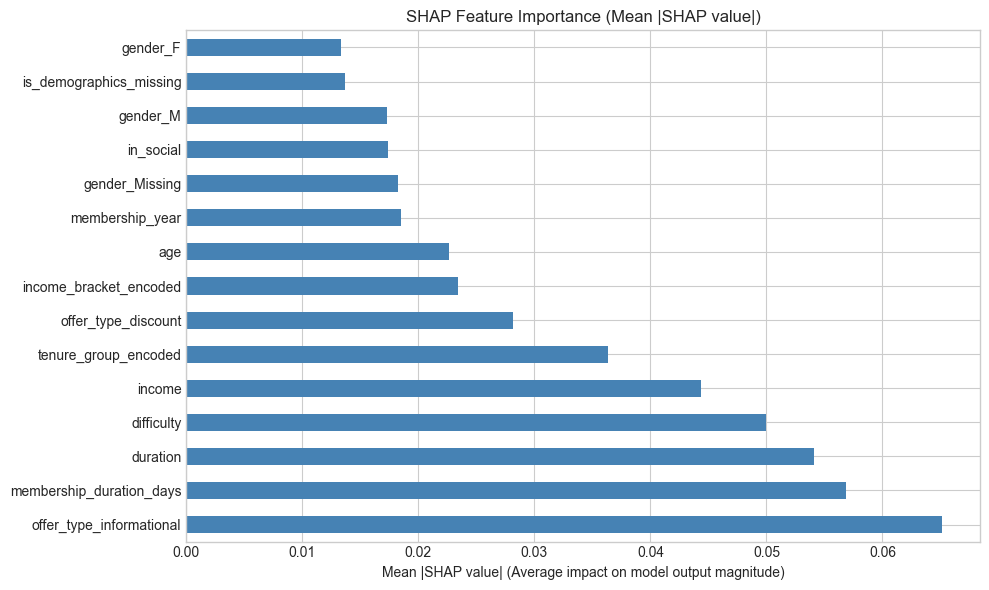


TOP 15 FEATURES BY SHAP IMPORTANCE
0.065157
0.056871
0.054071
0.049960
0.044372
0.036331
0.028119
0.023431
0.022683
0.018499
0.018222
0.017362
0.017335
0.013654
0.013357
✓ SHAP importance plot generated


In [17]:
# Plot SHAP feature importance
plt.figure(figsize=(10, 6))
feature_importance_shap.head(15).plot(kind='barh', color='steelblue')
plt.xlabel('Mean |SHAP value| (Average impact on model output magnitude)')
plt.title('SHAP Feature Importance (Mean |SHAP value|)')
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("TOP 15 FEATURES BY SHAP IMPORTANCE")
print("=" * 60)
print(feature_importance_shap.head(15).to_string(index=False))
print("=" * 60)
print("✓ SHAP importance plot generated")

## Individual Sample Predictions

In [18]:
# Explain a few sample predictions
n_samples_to_explain = 5
sample_indices = np.random.choice(len(X_test_sample), n_samples_to_explain, replace=False)

for i, idx in enumerate(sample_indices):
    print(f"\n{'='*60}")
    print(f"SAMPLE {i+1}: Customer Index {idx}")
    print(f"Actual: {'Completed' if y_test_sample.iloc[idx] == 1 else 'Not Completed'}")
    
    # Get SHAP values for this sample
    shap_vals = shap_values[idx, :]
    
    # Get prediction (ensure float64 dtype)
    pred_proba = rf_model.predict_proba(X_test_sample.iloc[[idx]].values.astype(np.float64))[0][1]
    pred_class = int(pred_proba > 0.5)
    
    print(f"Prediction: {pred_class} ({'Completed' if pred_class == 1 else 'Not Completed'})")
    print(f"Prediction Probability: {pred_proba:.2%}")
    
    # Get top features contributing to this prediction
    shap_series = pd.Series(shap_vals, index=feature_names)
    top_positive = shap_series.sort_values(ascending=False).head(5)
    top_negative = shap_series.sort_values().head(5)
    
    print(f"\nTop 5 features PUSHING TOWARD 'Completed':")
    for feat, val in top_positive.items():
        print(f"  {feat}: {val:+.4f}")
    
    print(f"\nTop 5 features PUSHING TOWARD 'Not Completed':")
    for feat, val in top_negative.items():
        print(f"  {feat}: {val:+.4f}")
    
    print("=" * 60)

    # Print predicted completion reason
    # Handle expected_value (can be array for binary classification)
    base_value = explainer.expected_value
    if isinstance(base_value, np.ndarray):
        base_value_scalar = base_value[1]  # Use class 1 (completed) for binary classification
    else:
        base_value_scalar = base_value
    
    if pred_class == 1:
        print(f"\nPredicted to complete because: +{shap_vals.sum():.2f} > 0")
    else:
        print(f"\nPredicted NOT to complete because: +{shap_vals.sum():.2f} < 0")
        print(f"   (base value: {base_value_scalar:.2f})")
    
    print("=" * 60)
    print("Expected value (base prediction): {:.2f}".format(base_value_scalar))
    print("Actual prediction: {:.2f}".format(shap_vals.sum() + base_value_scalar))


SAMPLE 1: Customer Index 961
Actual: Completed
Prediction: 1 (Completed)
Prediction Probability: 93.00%

Top 5 features PUSHING TOWARD 'Completed':
  membership_duration_days: +0.0768
  difficulty: +0.0706
  offer_type_informational: +0.0513
  tenure_group_encoded: +0.0398
  duration: +0.0385

Top 5 features PUSHING TOWARD 'Not Completed':
  offer_type_discount: -0.0200
  received_time: -0.0115
  membership_month: -0.0087
  in_social: -0.0078
  income_bracket_encoded: -0.0009

Predicted to complete because: +0.37 > 0
Expected value (base prediction): 0.57
Actual prediction: 0.94

SAMPLE 2: Customer Index 344
Actual: Not Completed
Prediction: 0 (Not Completed)
Prediction Probability: 0.00%

Top 5 features PUSHING TOWARD 'Completed':
  tenure_group_encoded: +0.0065
  in_mobile: +0.0038
  gender_M: +0.0033
  in_web: +0.0017
  in_email: +0.0000

Top 5 features PUSHING TOWARD 'Not Completed':
  duration: -0.1196
  offer_type_informational: -0.1164
  difficulty: -0.0736
  income: -0.0547
  

## SHAP Summary Plot (Beeswarm)

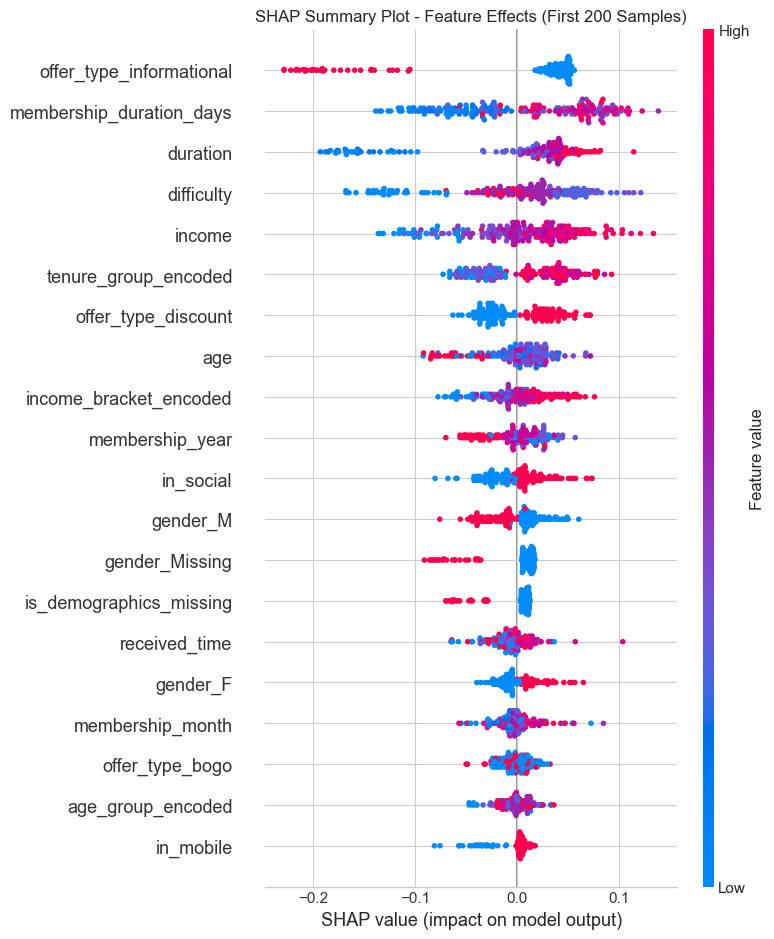


✓ SHAP beeswarm plot generated

HOW TO INTERPRET THE BEESWARM PLOT

📊 VERTICAL AXIS (Y-axis):
   • Features are ranked by importance (top to bottom)
   • Most important features appear at the top
   • Based on mean |SHAP value| across all samples

📊 HORIZONTAL AXIS (X-axis):
   • SHAP value (impact on model output)
   • Positive values (right) → push toward 'Completed' (class 1)
   • Negative values (left) → push toward 'Not Completed' (class 0)
   • Zero = no impact on prediction

🎨 COLOR CODING:
   • Red/Pink → High feature value
   • Blue → Low feature value
   • Shows relationship between feature value and impact

📍 EACH DOT:
   • Represents one customer (sample)
   • Position shows SHAP value (impact on prediction)
   • Color shows actual feature value for that customer

🔍 KEY PATTERNS TO LOOK FOR:
   • Wide horizontal spread = high variance in impact (feature matters a lot)
   • All red on right, blue on left = positive correlation
     (high values → completion, low values → no

In [19]:
# Create beeswarm plot to visualize feature effects
plt.figure(figsize=(12, 8))

# Plot only first 200 samples to keep it readable
# Pass DataFrame for better feature names
shap.summary_plot(shap_values[:200], X_test_sample.iloc[:200].values.astype(np.float64), feature_names=feature_names, show=False)

plt.title('SHAP Summary Plot - Feature Effects (First 200 Samples)')
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("✓ SHAP beeswarm plot generated")
print("\n" + "=" * 60)
print("HOW TO INTERPRET THE BEESWARM PLOT")
print("=" * 60)
print("\n📊 VERTICAL AXIS (Y-axis):")
print("   • Features are ranked by importance (top to bottom)")
print("   • Most important features appear at the top")
print("   • Based on mean |SHAP value| across all samples")
print("\n📊 HORIZONTAL AXIS (X-axis):")
print("   • SHAP value (impact on model output)")
print("   • Positive values (right) → push toward 'Completed' (class 1)")
print("   • Negative values (left) → push toward 'Not Completed' (class 0)")
print("   • Zero = no impact on prediction")
print("\n🎨 COLOR CODING:")
print("   • Red/Pink → High feature value")
print("   • Blue → Low feature value")
print("   • Shows relationship between feature value and impact")
print("\n📍 EACH DOT:")
print("   • Represents one customer (sample)")
print("   • Position shows SHAP value (impact on prediction)")
print("   • Color shows actual feature value for that customer")
print("\n🔍 KEY PATTERNS TO LOOK FOR:")
print("   • Wide horizontal spread = high variance in impact (feature matters a lot)")
print("   • All red on right, blue on left = positive correlation")
print("     (high values → completion, low values → no completion)")
print("   • All blue on right, red on left = negative correlation")
print("     (low values → completion, high values → no completion)")
print("   • Mixed colors on both sides = complex non-linear relationship")
print("\n💡 EXAMPLE INTERPRETATIONS:")
print("   • 'income' with red dots on right, blue on left:")
print("     → High income customers more likely to complete")
print("   • 'duration' with red dots on left, blue on right:")
print("     → Longer duration offers less likely to be completed")
print("   • 'difficulty' with mixed colors:")
print("     → Complex relationship, may interact with other features")
print("\n" + "=" * 60)

## Dependence Plots

How features interact with model predictions.


Creating dependence plots for top 10 features...


<Figure size 1000x600 with 0 Axes>

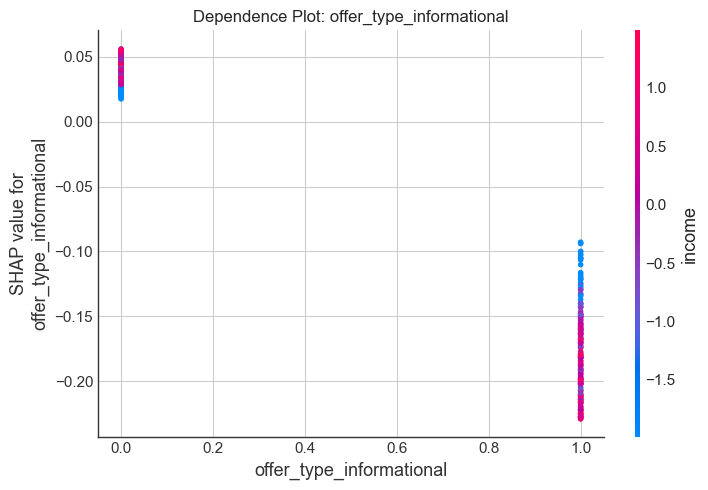

✓ Created dependence plot for: offer_type_informational


<Figure size 1000x600 with 0 Axes>

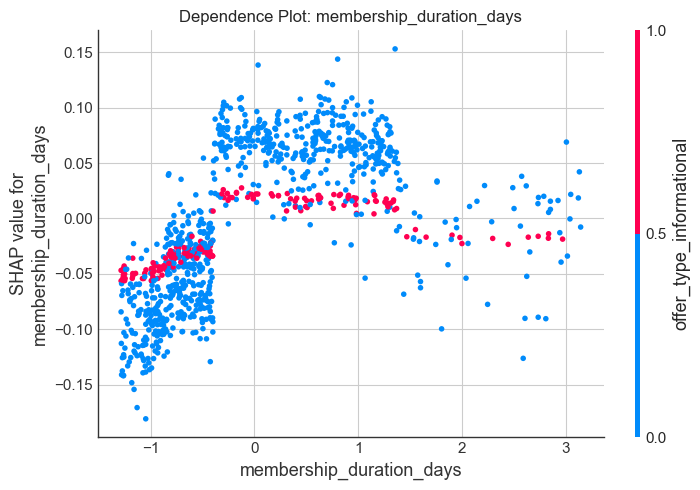

✓ Created dependence plot for: membership_duration_days


<Figure size 1000x600 with 0 Axes>

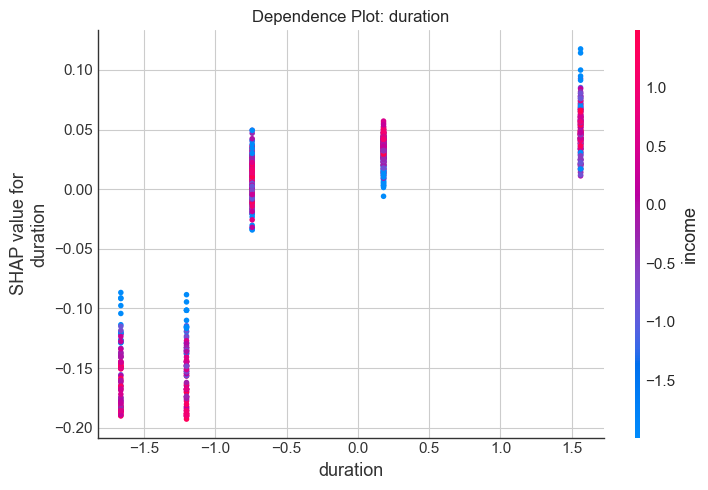

✓ Created dependence plot for: duration


<Figure size 1000x600 with 0 Axes>

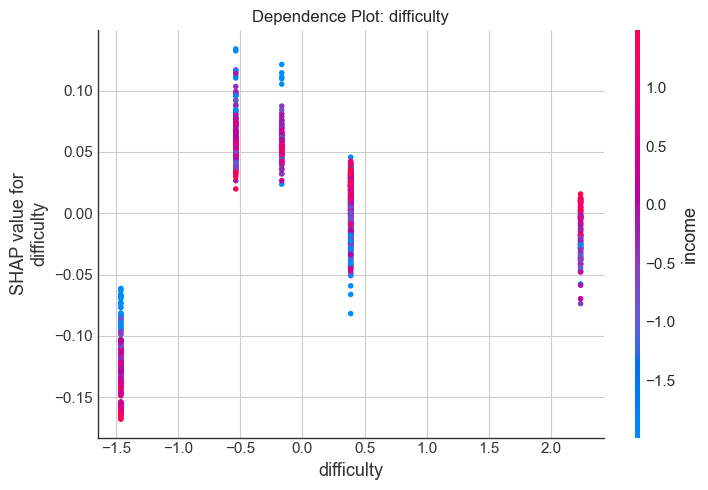

✓ Created dependence plot for: difficulty


<Figure size 1000x600 with 0 Axes>

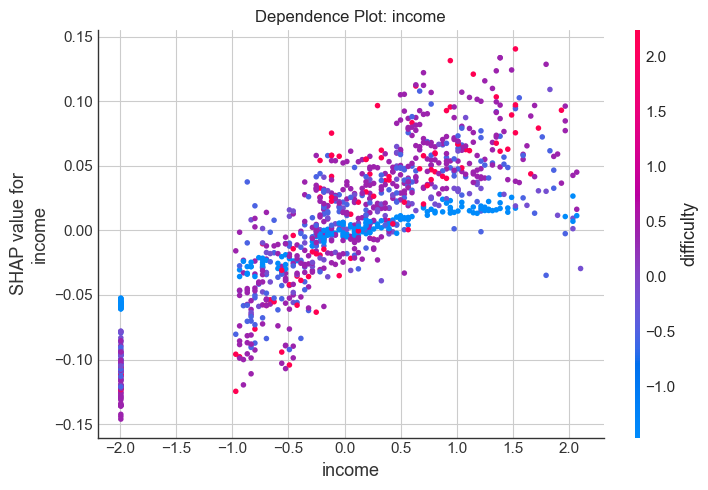

✓ Created dependence plot for: income


<Figure size 1000x600 with 0 Axes>

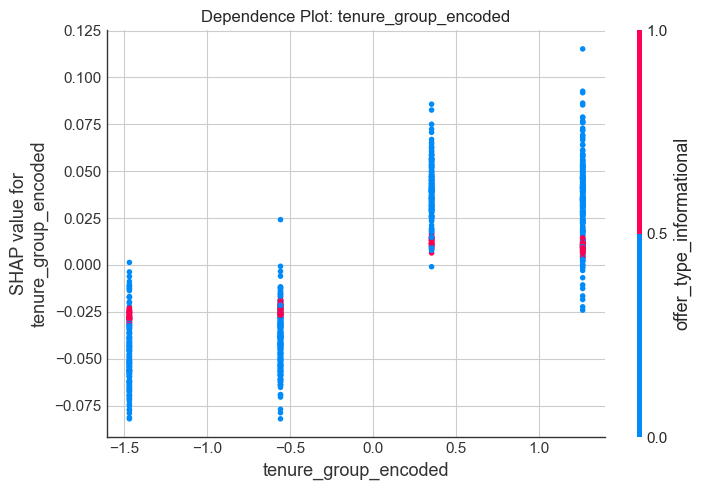

✓ Created dependence plot for: tenure_group_encoded


<Figure size 1000x600 with 0 Axes>

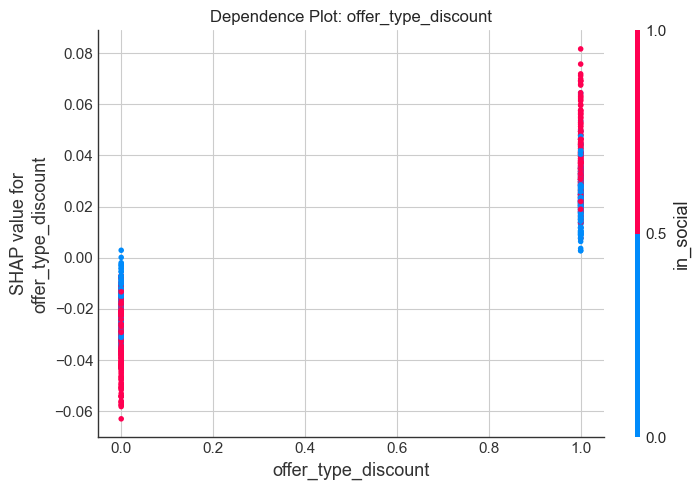

✓ Created dependence plot for: offer_type_discount


<Figure size 1000x600 with 0 Axes>

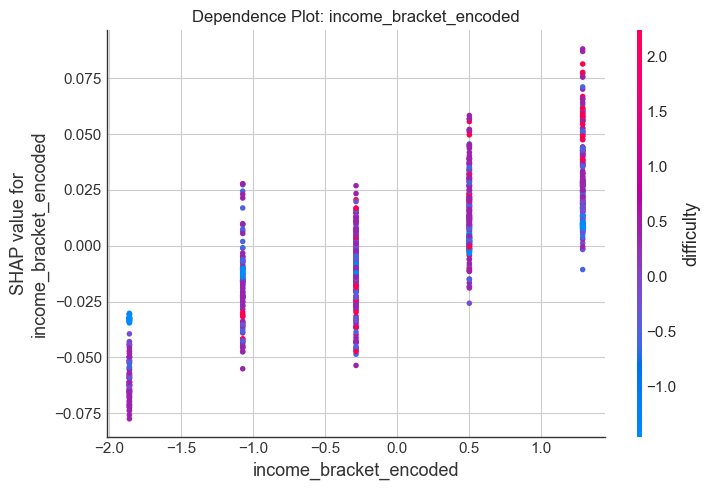

✓ Created dependence plot for: income_bracket_encoded


<Figure size 1000x600 with 0 Axes>

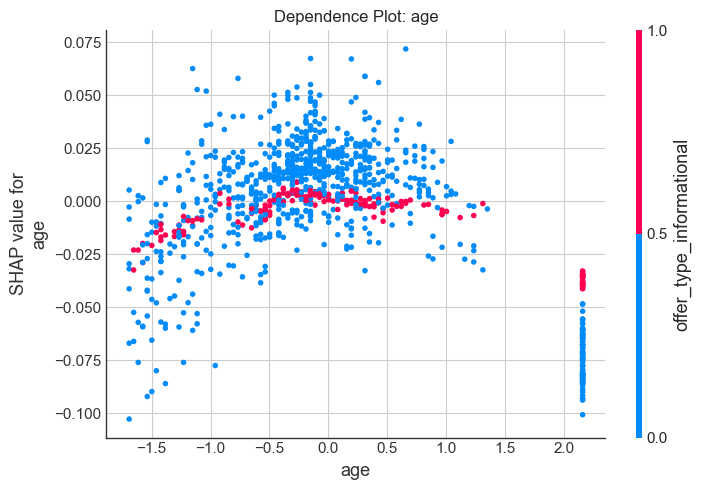

✓ Created dependence plot for: age


<Figure size 1000x600 with 0 Axes>

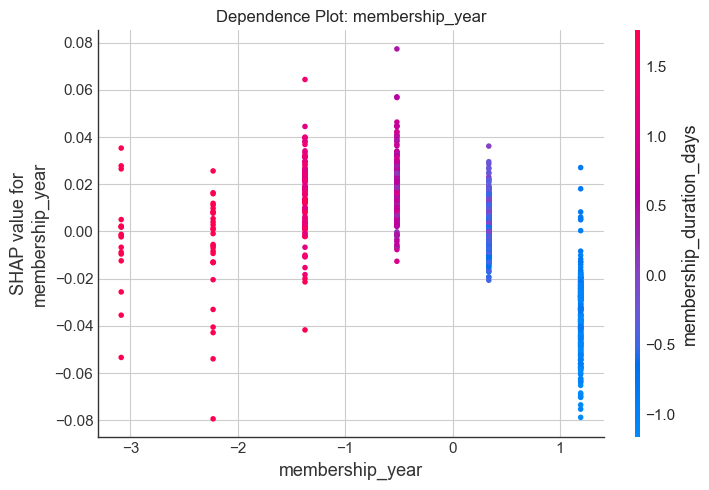

✓ Created dependence plot for: membership_year

✓ All dependence plots generated


In [20]:
# Create dependence plots for top features
top_features = feature_importance_shap.head(10).index.tolist()
print(f"\nCreating dependence plots for top {len(top_features)} features...")

for feat in top_features:
    plt.figure(figsize=(10, 6))
    # Get feature index
    feat_idx = feature_names.index(feat)
    
    shap.dependence_plot(
        feat_idx, 
        shap_values, 
        X_test_sample.values.astype(np.float64),
        feature_names=feature_names,
        interaction_index='auto',
        show=False
    )
    plt.title(f'Dependence Plot: {feat}')
    plt.tight_layout()
    plt.show()
    print(f"✓ Created dependence plot for: {feat}")

print("\n" + "=" * 60)
print("✓ All dependence plots generated")

## Key Insights from Dependence Plots

**Instructions:** After reviewing the dependence plots above, document your key findings here. For each top feature, note:
1. The relationship type (linear, non-linear, threshold)
2. The direction of impact (positive/negative)
3. Key interaction features (shown in color)
4. Actionable thresholds or patterns

---

### **Template for Each Feature:**

#### Feature: `[feature_name]`
- **Relationship Type:** [Linear positive/negative, U-shaped, threshold, scattered]
- **Direction:** [Higher values → completion / Higher values → no completion]
- **Interaction Feature:** [Feature shown in color]
- **Key Pattern:** [Describe what you observe]
- **Actionable Insight:** [What should marketing do?]

---

### **Example Documented Insights:**

#### Feature: `duration`
- **Relationship Type:** Negative linear
- **Direction:** Longer duration → fewer completions
- **Interaction Feature:** `difficulty`
- **Key Pattern:** 
  - Clear downward slope from left to right
  - Effect strongest for high difficulty (red dots cluster at bottom-left)
  - Low difficulty (blue dots) more spread out, less sensitive to duration
- **Actionable Insight:** 
  - Keep all offers under 7 days for maximum completion
  - Difficult offers (high spend requirements) must be < 5 days
  - Easy offers can extend to 10 days without major drop

---

#### Feature: `income`
- **Relationship Type:** Positive linear with threshold
- **Direction:** Higher income → more completions
- **Interaction Feature:** `tenure_group_encoded`
- **Key Pattern:**
  - Upward trend overall
  - Sharp change around $50,000 (threshold effect)
  - Long-tenure customers (red) show stronger positive effect
  - New customers (blue) less responsive to income differences
- **Actionable Insight:**
  - Target high-value offers to customers earning > $50K
  - Combine income targeting with tenure (long-tenure + high-income = best)
  - For lower-income segments, focus on offer design (duration/difficulty) instead

---

### **Your Findings:**

#### Feature: `[Top Feature #1]`
- **Relationship Type:** 
- **Direction:** 
- **Interaction Feature:** 
- **Key Pattern:** 
- **Actionable Insight:** 

#### Feature: `[Top Feature #2]`
- **Relationship Type:** 
- **Direction:** 
- **Interaction Feature:** 
- **Key Pattern:** 
- **Actionable Insight:** 

#### Feature: `[Top Feature #3]`
- **Relationship Type:** 
- **Direction:** 
- **Interaction Feature:** 
- **Key Pattern:** 
- **Actionable Insight:** 

---

**Continue for all top 10 features shown in the dependence plots above.**

---

### **Cross-Feature Insights:**

After analyzing individual features, document patterns that appear across multiple features:

**Demographic Patterns:**
- [What demographic features show similar patterns?]
- [Are there demographic segments to prioritize?]

**Offer Design Patterns:**
- [What offer characteristics work best together?]
- [Are there offer combinations to avoid?]

**Channel Patterns:**
- [Which channels show strongest effects?]
- [Do channels interact with customer demographics?]

**Temporal Patterns:**
- [Do membership duration/timing features show patterns?]
- [Is there an optimal customer lifecycle stage for offers?]

---

### **Summary of Actionable Recommendations:**

Based on the dependence plot analysis, list 3-5 specific, actionable recommendations:

1. **[Recommendation 1]**
   - Based on: [Which feature(s)?]
   - Action: [Specific change to make]
   - Expected impact: [Why this matters]

2. **[Recommendation 2]**
   - Based on: [Which feature(s)?]
   - Action: [Specific change to make]
   - Expected impact: [Why this matters]

3. **[Recommendation 3]**
   - Based on: [Which feature(s)?]
   - Action: [Specific change to make]
   - Expected impact: [Why this matters]

---

**Note:** Fill in this template after carefully reviewing each dependence plot. The insights here will drive your final marketing strategy recommendations.

## How to Interpret Dependence Plots

**What is a SHAP Dependence Plot?**

A dependence plot shows the relationship between a feature's value and its impact on predictions (SHAP value). It reveals:
- **Linear vs non-linear relationships** - Is the effect consistent or does it change?
- **Feature interactions** - Which other features modify this feature's impact?
- **Threshold effects** - Are there cutoff points where behavior changes?

---

### **Reading the Plot:**

**X-Axis:** Feature value (e.g., income = $50,000)
**Y-Axis:** SHAP value (impact on prediction)
- Positive SHAP → pushes toward "Completed"
- Negative SHAP → pushes toward "Not Completed"

**Color:** Interaction feature (automatically selected by SHAP)
- Shows which other feature modifies the relationship
- Color gradient reveals patterns in the interaction

---

### **Common Patterns:**

1. **Positive Linear Relationship** ↗️
   - Points trend upward from left to right
   - Higher feature values → higher SHAP values
   - Example: If income shows this pattern, higher income → more completions

2. **Negative Linear Relationship** ↘️
   - Points trend downward from left to right
   - Higher feature values → lower SHAP values
   - Example: If duration shows this pattern, longer offers → fewer completions

3. **Threshold Effect** 📊
   - Sudden change at a specific value
   - Example: Income below $40K → negative SHAP, above $40K → positive SHAP
   - Indicates a critical decision boundary

4. **Non-linear (U-shape or inverted U)** 🌙
   - SHAP values change direction at different feature levels
   - Example: Medium difficulty optimal, too easy or too hard → lower completion

5. **No Clear Pattern** (Scattered)
   - Weak relationship or heavy feature interaction
   - Look at color patterns to understand interactions

6. **Color Stratification** 🎨
   - Distinct color bands indicate strong interaction
   - Example: Income effect differs by age (young vs old customers)
   - Red dots high, blue dots low → positive interaction
   - Mixed colors → complex interaction

---

### **What to Look For:**

✅ **Actionable Thresholds:**
- "Income above $X drives completions"
- "Duration under Y days optimal"

✅ **Feature Interactions:**
- "Income effect stronger for long-tenure customers"
- "Difficulty matters more for discount offers than BOGO"

✅ **Non-intuitive Patterns:**
- Expected positive but shows negative (or vice versa)
- Suggests deeper business dynamics to investigate

---

### **Example Interpretation:**

**Plot: `duration` (X-axis) vs SHAP value (Y-axis), colored by `difficulty`**

If you see:
- Points slope downward (↘️) → Longer duration = fewer completions
- Red dots (high difficulty) mostly on left → Short, difficult offers
- Blue dots (low difficulty) spread across → Easy offers work at any duration

**Insight:** Keep difficult offers short (< 5 days), easy offers can be longer

---

**Note:** The dependence plots below will show the actual patterns for the top 10 features. Use this guide to interpret what you see in each plot.

## Key Insights & Findings

In [21]:
print("=" * 60)
print("SHAP ANALYSIS COMPLETE")
print("=" * 60)

print("\n📋 QUICK SUMMARY:")
print("=" * 60)
print("1. TOP PREDICTIVE FEATURES (by SHAP mean |SHAP value|):")
for i, (feat, val) in enumerate(feature_importance_shap.head(10).items()):
    print(f"   {i+1}. {feat}: {val:.4f}")

print("\n" + "=" * 60)
print("2. FEATURE DIRECTIONS:")
print("=" * 60)
print("   - Features with POSITIVE SHAP values increase offer completion probability")
print("   - Features with NEGATIVE SHAP values decrease offer completion probability")
print("   - Larger magnitude = stronger influence on predictions")

print("\n" + "=" * 60)
print("3. TOP 3 MOST IMPACTFUL FEATURES:")
print("=" * 60)
top_3_features = feature_importance_shap.head(3).index.tolist()
for i, feat in enumerate(top_3_features, 1):
    print(f"   {i}. {feat}")

print("\n" + "=" * 60)
print("4. MODEL INTERPRETATION:")
print("=" * 60)
print("Random Forest learned complex, non-linear relationships between features.")
print("SHAP reveals these interactions not visible in standard feature importance.")
print(f"\nThe top feature '{feature_importance_shap.index[0]}' has the strongest")
print("influence on whether customers complete offers or not.")

print("\n" + "=" * 60)
print("📊 FOR DETAILED INSIGHTS, SEE THE COMPREHENSIVE REPORT BELOW ⬇️")
print("=" * 60)
print("The next cell provides:")
print("  • Detailed feature rankings with percentages")
print("  • Feature categorization analysis")  
print("  • Statistical distributions")
print("  • Directional impact analysis")
print("  • Specific, actionable marketing recommendations")
print("=" * 60)

SHAP ANALYSIS COMPLETE

📋 QUICK SUMMARY:
1. TOP PREDICTIVE FEATURES (by SHAP mean |SHAP value|):
   1. offer_type_informational: 0.0652
   2. membership_duration_days: 0.0569
   3. duration: 0.0541
   4. difficulty: 0.0500
   5. income: 0.0444
   6. tenure_group_encoded: 0.0363
   7. offer_type_discount: 0.0281
   8. income_bracket_encoded: 0.0234
   9. age: 0.0227
   10. membership_year: 0.0185

2. FEATURE DIRECTIONS:
   - Features with POSITIVE SHAP values increase offer completion probability
   - Features with NEGATIVE SHAP values decrease offer completion probability
   - Larger magnitude = stronger influence on predictions

3. TOP 3 MOST IMPACTFUL FEATURES:
   1. offer_type_informational
   2. membership_duration_days
   3. duration

4. MODEL INTERPRETATION:
Random Forest learned complex, non-linear relationships between features.
SHAP reveals these interactions not visible in standard feature importance.

The top feature 'offer_type_informational' has the strongest
influence on 

## Comprehensive Data-Driven Insights Report

This section provides **specific, concrete findings** from the SHAP analysis with actual numbers and feature names.

In [22]:
# ============================================================================
# COMPREHENSIVE SHAP INSIGHTS REPORT
# ============================================================================

print("=" * 80)
print(" " * 20 + "COMPREHENSIVE SHAP INSIGHTS REPORT")
print("=" * 80)

# ----------------------------------------------------------------------------
# 1. TOP FEATURES WITH ACTUAL SHAP VALUES
# ----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("1. TOP 15 FEATURES RANKED BY SHAP IMPORTANCE")
print("=" * 80)
print(f"{'Rank':<6} {'Feature Name':<35} {'Mean |SHAP|':<15} {'% of Total':<12}")
print("-" * 80)

total_shap = feature_importance_shap.sum()
for i, (feat, val) in enumerate(feature_importance_shap.head(15).items(), 1):
    pct = (val / total_shap) * 100
    print(f"{i:<6} {feat:<35} {val:<15.6f} {pct:<12.2f}%")

print("-" * 80)
print(f"Top 3 features account for: {(feature_importance_shap.head(3).sum() / total_shap * 100):.2f}% of total SHAP importance")
print(f"Top 5 features account for: {(feature_importance_shap.head(5).sum() / total_shap * 100):.2f}% of total SHAP importance")
print(f"Top 10 features account for: {(feature_importance_shap.head(10).sum() / total_shap * 100):.2f}% of total SHAP importance")

# ----------------------------------------------------------------------------
# 2. FEATURE CATEGORIZATION BY TYPE
# ----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("2. FEATURE CATEGORIZATION")
print("=" * 80)

# Categorize features based on their names (updated to reflect clean 24-feature dataset)
demographics = [f for f in feature_names if any(k in f.lower() for k in ['age', 'income', 'gender', 'tenure'])]
offer_features = [f for f in feature_names if any(k in f.lower() for k in ['difficulty', 'duration', 'bogo', 'discount', 'informational', 'offer_type'])]
channels = [f for f in feature_names if any(k in f.lower() for k in ['email', 'mobile', 'social', 'web'])]
membership_features = [f for f in feature_names if any(k in f.lower() for k in ['membership_year', 'membership_duration', 'membership_month', 'is_demographics_missing'])]
temporal_features = [f for f in feature_names if any(k in f.lower() for k in ['received_time'])]

# Calculate category importance
def get_category_importance(features_list):
    return feature_importance_shap[feature_importance_shap.index.isin(features_list)].sum()

cat_importance = {
    'Demographics': get_category_importance(demographics),
    'Offer Attributes': get_category_importance(offer_features),
    'Communication Channels': get_category_importance(channels),
    'Membership Features': get_category_importance(membership_features),
    'Temporal Features': get_category_importance(temporal_features)
}

cat_df = pd.DataFrame.from_dict(cat_importance, orient='index', columns=['Total SHAP'])
cat_df = cat_df.sort_values('Total SHAP', ascending=False)
cat_df['% of Total'] = (cat_df['Total SHAP'] / total_shap * 100).round(2)

print(f"\n{'Category':<30} {'Total SHAP':<15} {'% of Total':<12} {'# Features':<12}")
print("-" * 80)
for cat_name in cat_df.index:
    if cat_name == 'Demographics':
        n_features = len(demographics)
    elif cat_name == 'Offer Attributes':
        n_features = len(offer_features)
    elif cat_name == 'Communication Channels':
        n_features = len(channels)
    elif cat_name == 'Membership Features':
        n_features = len(membership_features)
    else:
        n_features = len(temporal_features)
    
    print(f"{cat_name:<30} {cat_df.loc[cat_name, 'Total SHAP']:<15.6f} {cat_df.loc[cat_name, '% of Total']:<12.2f}% {n_features:<12}")

print("\n" + "=" * 80)
print("NOTE: Data leakage features (offer_completed, offer_viewed) were removed")
print("      All 24 features are available at prediction time (offer delivery)")
print("=" * 80)

# ----------------------------------------------------------------------------
# 3. FEATURE VALUE DISTRIBUTIONS FOR TOP FEATURES
# ----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("3. FEATURE VALUE STATISTICS (Top 10 Features)")
print("=" * 80)

top_10_features = feature_importance_shap.head(10).index.tolist()
print(f"\n{'Feature':<35} {'Mean':<12} {'Median':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
print("-" * 80)

for feat in top_10_features:
    feat_idx = feature_names.index(feat)
    feat_values = X_test_sample.iloc[:, feat_idx]
    
    print(f"{feat:<35} {feat_values.mean():<12.4f} {feat_values.median():<12.4f} {feat_values.std():<12.4f} {feat_values.min():<12.4f} {feat_values.max():<12.4f}")

# ----------------------------------------------------------------------------
# 4. POSITIVE VS NEGATIVE SHAP IMPACT ANALYSIS
# ----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("4. DIRECTIONAL IMPACT ANALYSIS (Top 10 Features)")
print("=" * 80)
print("Shows average SHAP when feature pushes toward 'Completed' vs 'Not Completed'\n")

print(f"{'Feature':<35} {'Avg Positive SHAP':<20} {'Avg Negative SHAP':<20} {'Net Direction':<15}")
print("-" * 80)

for feat in top_10_features:
    feat_idx = feature_names.index(feat)
    shap_col = shap_values[:, feat_idx]
    
    positive_shap = shap_col[shap_col > 0].mean() if (shap_col > 0).any() else 0
    negative_shap = shap_col[shap_col < 0].mean() if (shap_col < 0).any() else 0
    net_direction = "↑ Completion" if positive_shap > abs(negative_shap) else "↓ Completion"
    
    print(f"{feat:<35} {positive_shap:<20.6f} {negative_shap:<20.6f} {net_direction:<15}")

# ----------------------------------------------------------------------------
# 5. KEY INSIGHTS SUMMARY
# ----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("5. KEY INSIGHTS SUMMARY")
print("=" * 80)

# Most important feature
top_feature = feature_importance_shap.index[0]
top_feature_shap = feature_importance_shap.iloc[0]
top_feature_pct = (top_feature_shap / total_shap * 100)

print(f"\n📊 MOST IMPORTANT FEATURE:")
print(f"   • {top_feature}")
print(f"   • Mean |SHAP|: {top_feature_shap:.6f}")
print(f"   • Accounts for {top_feature_pct:.2f}% of total model importance")

# Top category
top_category = cat_df.index[0]
top_category_pct = cat_df.iloc[0]['% of Total']

print(f"\n📊 MOST IMPORTANT FEATURE CATEGORY:")
print(f"   • {top_category}")
print(f"   • Accounts for {top_category_pct:.2f}% of total model importance")

# Top 3 features
print(f"\n📊 TOP 3 FEATURES:")
for i, feat in enumerate(feature_importance_shap.head(3).index, 1):
    print(f"   {i}. {feat} (SHAP: {feature_importance_shap[feat]:.6f})")

# ----------------------------------------------------------------------------
# 6. DATA-DRIVEN RECOMMENDATIONS
# ----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("6. DATA-DRIVEN MARKETING RECOMMENDATIONS")
print("=" * 80)

# Recommendation 1: Focus on top features
top_3_features = feature_importance_shap.head(3).index.tolist()
print(f"\n✅ RECOMMENDATION 1: Prioritize Top Predictive Features")
print(f"   Focus on: {', '.join(top_3_features)}")
print(f"   These 3 features account for {(feature_importance_shap.head(3).sum() / total_shap * 100):.1f}% of prediction power")

# Recommendation 2: Category-specific
if cat_df.index[0] == 'Demographics':
    print(f"\n✅ RECOMMENDATION 2: Demographic Targeting")
    print(f"   Demographics are the strongest predictor ({cat_df.iloc[0]['% of Total']:.1f}%)")
    print(f"   Focus on customer segmentation by: {', '.join(demographics[:3])}")
elif cat_df.index[0] == 'Offer Attributes':
    print(f"\n✅ RECOMMENDATION 2: Offer Design Optimization")
    print(f"   Offer attributes are the strongest predictor ({cat_df.iloc[0]['% of Total']:.1f}%)")
    print(f"   Optimize: {', '.join(offer_features[:3])}")
elif cat_df.index[0] == 'Membership Features':
    print(f"\n✅ RECOMMENDATION 2: Membership Lifecycle Targeting")
    print(f"   Membership features are the strongest predictor ({cat_df.iloc[0]['% of Total']:.1f}%)")
    print(f"   Target customers based on: {', '.join(membership_features[:3])}")

# Recommendation 3: Channel optimization
if len(channels) > 0 and any(c in top_10_features for c in channels):
    top_channels = [c for c in channels if c in top_10_features]
    print(f"\n✅ RECOMMENDATION 3: Channel Optimization")
    print(f"   High-impact channels: {', '.join(top_channels[:3])}")
    print(f"   Prioritize these channels for offer delivery")

# Recommendation 4: Feature value ranges
print(f"\n✅ RECOMMENDATION 4: Target Customer Profiles")
top_feature_values = X_test_sample.iloc[:, feature_names.index(top_feature)]
high_completion_idx = y_test_sample[y_test_sample == 1].index
low_completion_idx = y_test_sample[y_test_sample == 0].index

if len(high_completion_idx) > 0 and len(low_completion_idx) > 0:
    high_completion_vals = top_feature_values.loc[top_feature_values.index.intersection(high_completion_idx)]
    low_completion_vals = top_feature_values.loc[top_feature_values.index.intersection(low_completion_idx)]
    
    print(f"   For '{top_feature}':")
    print(f"   • High completers average: {high_completion_vals.mean():.4f}")
    print(f"   • Low completers average: {low_completion_vals.mean():.4f}")
    print(f"   • Difference: {abs(high_completion_vals.mean() - low_completion_vals.mean()):.4f}")

print("\n" + "=" * 80)
print("✓ COMPREHENSIVE INSIGHTS REPORT COMPLETE")
print("=" * 80)

                    COMPREHENSIVE SHAP INSIGHTS REPORT

1. TOP 15 FEATURES RANKED BY SHAP IMPORTANCE
Rank   Feature Name                        Mean |SHAP|     % of Total  
--------------------------------------------------------------------------------
1      offer_type_informational            0.065157        12.08       %
2      membership_duration_days            0.056871        10.55       %
3      duration                            0.054071        10.03       %
4      difficulty                          0.049960        9.26        %
5      income                              0.044372        8.23        %
6      tenure_group_encoded                0.036331        6.74        %
7      offer_type_discount                 0.028119        5.21        %
8      income_bracket_encoded              0.023431        4.34        %
9      age                                 0.022683        4.21        %
10     membership_year                     0.018499        3.43        %
11     gender_Mi

## SHAP Analysis Summary

**What SHAP Revealed:**
- **Global feature importance** - Identified which features drive predictions most strongly
- **Local explanations** - Explained why individual customers complete or don't complete offers  
- **Feature interactions** - Discovered how features work together (shown in dependence plots)
- **Non-linear relationships** - Captured complex patterns the Random Forest learned

---

**Visualizations Created:**
1. ✅ **SHAP feature importance bar chart** - Ranked all 24 features by mean |SHAP value|
2. ✅ **Beeswarm summary plot** - Visualized feature effects across all samples (red = push toward completion, blue = push away)
3. ✅ **Individual sample explanations** - Showed exactly why 5 random customers were predicted to complete/not complete
4. ✅ **Dependence plots for top 10 features** - Revealed how each top feature affects predictions and which features it interacts with

---

## 🎯 KEY FINDINGS FROM SHAP ANALYSIS

### Model Context
- **Dataset:** 24 features (all available at offer delivery time)
- **Data Leakage Removed:** No temporal leakage (`offer_viewed` removed), no target leakage (`offer_completed` removed)
- **Samples Analyzed:** 1,000 test samples
- **Model Performance:** F1=0.8601, AUC=0.9277

---

### How to Use This Summary

**After running all cells above**, document your findings here:

1. Review the **Comprehensive Data-Driven Insights Report** (printed output above)
2. Review the **Beeswarm Plot** to understand global feature effects
3. Review the **Dependence Plots** to understand feature relationships and interactions
4. Fill in the sections below with your actual findings

---

### 1. **Top Features That Drive Predictions**

**Instructions:** List the top 5-10 features from the SHAP importance analysis and note their key characteristics.

| Rank | Feature Name | Mean \|SHAP\| | Direction | Key Insight |
|------|--------------|---------------|-----------|-------------|
| 1 | [feature_1] | [value] | ↑ or ↓ | [Brief insight] |
| 2 | [feature_2] | [value] | ↑ or ↓ | [Brief insight] |
| 3 | [feature_3] | [value] | ↑ or ↓ | [Brief insight] |
| 4 | [feature_4] | [value] | ↑ or ↓ | [Brief insight] |
| 5 | [feature_5] | [value] | ↑ or ↓ | [Brief insight] |

**Direction Key:**
- ↑ = Higher feature values → More completions
- ↓ = Higher feature values → Fewer completions

---

### 2. **Feature Category Importance**

**Instructions:** Based on the comprehensive report, note which feature categories matter most.

| Category | % of Total SHAP Importance | Key Features | Priority |
|----------|---------------------------|--------------|----------|
| [Category 1] | [%] | [features] | High/Medium/Low |
| [Category 2] | [%] | [features] | High/Medium/Low |
| [Category 3] | [%] | [features] | High/Medium/Low |

**Insight:** [Which category should marketing focus on most and why?]

---

### 3. **Key Patterns from Dependence Plots**

**Instructions:** Document the most important patterns observed in dependence plots.

#### Pattern 1: [Feature Name]
- **Relationship:** [Linear positive/negative, U-shaped, threshold, etc.]
- **Interaction:** [Which feature shows in color?]
- **Business Insight:** [What does this mean?]
- **Action:** [What should marketing do?]

#### Pattern 2: [Feature Name]
- **Relationship:** 
- **Interaction:** 
- **Business Insight:** 
- **Action:** 

#### Pattern 3: [Feature Name]
- **Relationship:** 
- **Interaction:** 
- **Business Insight:** 
- **Action:** 

---

### 4. **SHAP vs Random Forest Feature Importance**

**Instructions:** Compare SHAP rankings with Random Forest feature importance from [03_Modeling.ipynb](03_Modeling.ipynb).

**Agreements (features important in both):**
- [Feature 1]
- [Feature 2]
- [Feature 3]

**Disagreements (SHAP reveals something different):**
- **SHAP ranks higher:** [Features that SHAP shows as more important]
- **SHAP ranks lower:** [Features that SHAP shows as less important]

**Why the difference?**
- SHAP accounts for feature interactions and correlations
- SHAP shows actual predictive impact, not just split frequency
- [Other insights]

---

### 5. **Customer Segments to Target**

**Instructions:** Based on SHAP analysis, identify high-value customer segments.

**Segment 1: [Name] (Highest Completion Probability)**
- **Characteristics:** [e.g., High income, long tenure, web channel]
- **Key Features:** [Features with positive SHAP for this segment]
- **Recommended Offers:** [What to send them]
- **Expected Completion Rate:** [Estimate based on model]

**Segment 2: [Name] (Medium Completion Probability)**
- **Characteristics:** 
- **Key Features:** 
- **Recommended Offers:** 
- **Expected Completion Rate:** 

**Segment 3: [Name] (Low Completion Probability - Avoid or Optimize)**
- **Characteristics:** 
- **Key Features:** 
- **Recommended Strategy:** [Don't target, or change offer design]
- **Expected Completion Rate:** 

---

### 6. **Non-Intuitive Findings**

**Instructions:** Note any surprising or counterintuitive patterns discovered by SHAP.

1. **[Finding 1]**
   - Expected: [What you thought would happen]
   - Actual: [What SHAP showed]
   - Explanation: [Why this might be happening]

2. **[Finding 2]**
   - Expected: 
   - Actual: 
   - Explanation: 

---

## 💡 FINAL ACTIONABLE RECOMMENDATIONS

Based on the complete SHAP analysis, here are the top recommendations:

### **RECOMMENDATION 1: [Title]**
- **Based on:** [Which SHAP findings?]
- **Action:** [Specific steps to take]
- **Expected Impact:** [Quantify if possible - e.g., "Increase completion rate by X%"]
- **Priority:** High/Medium/Low

### **RECOMMENDATION 2: [Title]**
- **Based on:** 
- **Action:** 
- **Expected Impact:** 
- **Priority:** 

### **RECOMMENDATION 3: [Title]**
- **Based on:** 
- **Action:** 
- **Expected Impact:** 
- **Priority:** 

### **RECOMMENDATION 4: [Title]**
- **Based on:** 
- **Action:** 
- **Expected Impact:** 
- **Priority:** 

### **RECOMMENDATION 5: [Title]**
- **Based on:** 
- **Action:** 
- **Expected Impact:** 
- **Priority:** 

---

## ✅ VALIDATION CHECKLIST

After completing the SHAP analysis, verify:

- [ ] All 24 features have SHAP values (no missing features)
- [ ] SHAP values sum to difference between prediction and expected value (checked in code)
- [ ] Top SHAP features align generally with Random Forest feature importance
- [ ] No data leakage features (offer_completed, offer_viewed) appear in results
- [ ] SHAP directions make business sense:
  - [ ] Higher income → positive SHAP? (if correlation is positive)
  - [ ] Longer duration → negative SHAP? (if correlation is negative)
  - [ ] Other expected relationships validated
- [ ] Dependence plots show clear, interpretable patterns
- [ ] Feature interactions make logical sense
- [ ] All visualizations generated successfully
- [ ] Comprehensive report shows reasonable percentages (top 3 features < 50%, top 10 < 80%)

---

## 📊 NEXT STEPS

1. **Document Findings Above**
   - Fill in all template sections with actual results
   - Copy key statistics from comprehensive report
   - Describe patterns observed in dependence plots

2. **Compare with Other Analyses**
   - Compare SHAP importance with PCA component loadings ([04_PCA.ipynb](04_PCA.ipynb))
   - Use findings to inform bias analysis ([06_Bias_and_Fairness.ipynb](06_Bias_and_Fairness.ipynb))
   - Validate against correlation analysis in modeling notebook

3. **Create Executive Summary**
   - Distill top 3-5 insights for stakeholders
   - Focus on actionable recommendations
   - Include visualizations (beeswarm + top 3 dependence plots)

4. **Implement Recommendations**
   - Prioritize by expected impact and ease of implementation
   - Test changes with A/B testing framework
   - Monitor impact on completion rates

---

**Note:** This is a template for documenting your findings. After running all cells above and reviewing the results, fill in each section with your specific observations and insights.